In [7]:
import os
import glob
import torchvision
from json import load
from pandas.io.json import json_normalize
import tifffile as ti
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
from torch_snippets import *
from PIL import Image
import plotly.express as px

/opt/homebrew/lib/python3.11/site-packages/torch/distributed/_shard/partial_tensor.py:40: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)
/opt/homebrew/lib/python3.11/site-packages/torch/distributed/_shard/replicated_tensor.py:20: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)


In [9]:
# Set directories and filenames
IMAGE_ROOT = './images/'
LABEL_ROOT = './labels/'
MODEL_PATH = './model/'
model_save_name = 'diatom-model_10epochs_test.pt'
IMAGE_PREPEND = 'data1_'
# IMAGE_PREPEND = 'diatome_test_img'

In [10]:
with open(LABEL_ROOT + 'df_old.json') as json_data:
# with open(LABEL_ROOT + 'df_old.json') as json_data:
    data = load(json_data)
    pass

temp_df = pd.DataFrame(data['annotations'])
images_df = pd.DataFrame(data['images'])
categories_df = pd.DataFrame(data['categories']).iloc[:, 1:3]


In [11]:
print(temp_df.columns)
print(images_df.columns)
print(categories_df.columns)
print(categories_df)
temp_df.bbox[0:5]

Index(['segmentation', 'area', 'iscrowd', 'ignore', 'image_id', 'bbox',
       'category_id', 'id'],
      dtype='object')

Index(['id', 'file_name', 'width', 'height'], dtype='object')

Index(['id', 'name'], dtype='object')

id    name
0   1  diatom

0     [100, 248, 10, 20]
1    [1250, 226, 22, 13]
2    [1183, 209, 12, 22]
3    [1147, 219, 23, 12]
4    [1177, 306, 20, 14]
Name: bbox, dtype: object

In [12]:
ar = temp_df.bbox[0]
DF_RAW = df = pd.DataFrame(columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])

X_FACTOR = 1392
Y_FACTOR = 1040

for index, row in temp_df.iterrows():
    ar = row.bbox
    xMin = ar[0]
    xMax = ar[0] + ar[2]
    yMin = ar[1]
    yMax = ar[1] + ar[3]
    #print(row.image_id)
    imageId = IMAGE_PREPEND + str(int(row.image_id) - 1)
    labelName = ''
    if row.category_id == 1:
        labelName = 'diatom'
        pass
    data = [[imageId, labelName, xMin / X_FACTOR, xMax / X_FACTOR, yMin / Y_FACTOR, yMax / Y_FACTOR]]
    frame = pd.DataFrame(data, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])
    df = pd.concat([df, frame], axis=0)
    pass

In [13]:
df = df.astype({'ImageID' : 'string', 'LabelName' : 'string', 'XMin' : 'float32', 'XMax' : 'float32', 'YMin' : 'float32', 'YMax' : 'float32'})
DF_RAW = df

In [14]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [15]:
def preprocess_image(img):
    # img = torch.tensor(img, dtype=torch.float32).permute(2,0,1)
    img = torch.tensor(img, dtype=torch.float64).permute(2,0,1)
    return img.to(device).float()

In [16]:
class OpenDataset(torch.utils.data.Dataset):
    # w, h = 224, 224
    w, h = 1392 * 2,1040 * 2
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        return
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id + ".png", self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.Resampling.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)
    pass


In [17]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]


train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)


train_loader = DataLoader(train_ds, batch_size=3, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=3, collate_fn=test_ds.collate_fn, drop_last=True)

In [18]:
device = ""
if torch.backends.mps.is_available():
    device = "mps" #torch.device("mps")
    pass
else:
    device = "cpu"
    pass

device = "cpu"
print(f"Device: {device}")

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Device: cpu

In [19]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [20]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.85, weight_decay=0.0005)
# n_epochs = 5
n_epochs = 10
log = Report(n_epochs)

In [21]:

for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    # if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 10.000  val_loss: 0.745  val_loc_loss: 0.130  val_regr_loss: 0.453  val_objectness_loss: 0.062  val_rpn_box_reg_loss: 0.101  (1086.13s - 0.00s remaining))

100%|██████████████████████████████████████| 111/111 [00:00<00:00, 62534.28it/s]


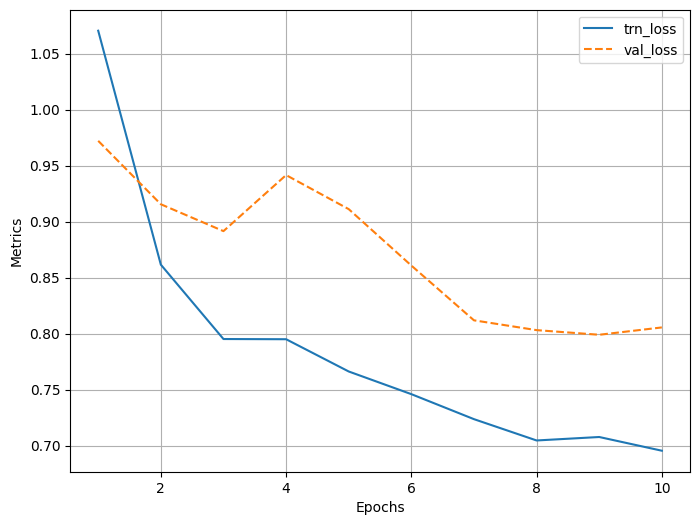

In [22]:
log.plot_epochs(['trn_loss','val_loss'])

In [23]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


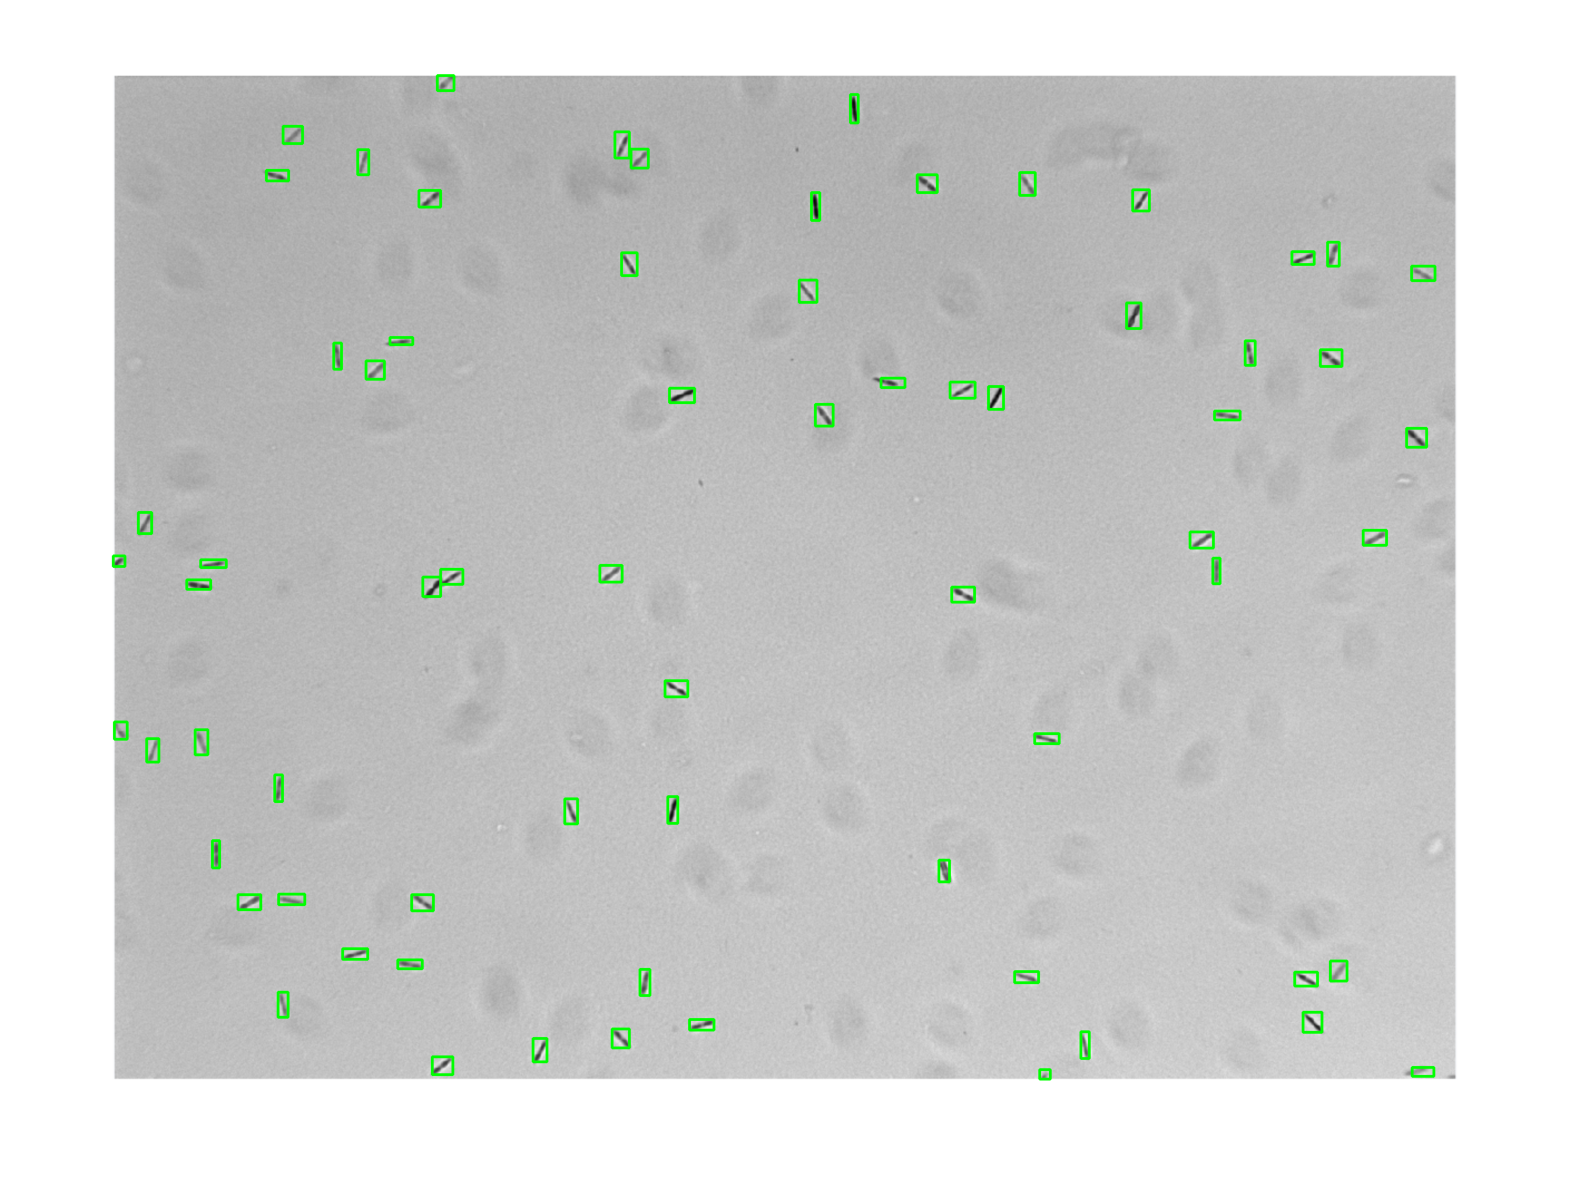

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


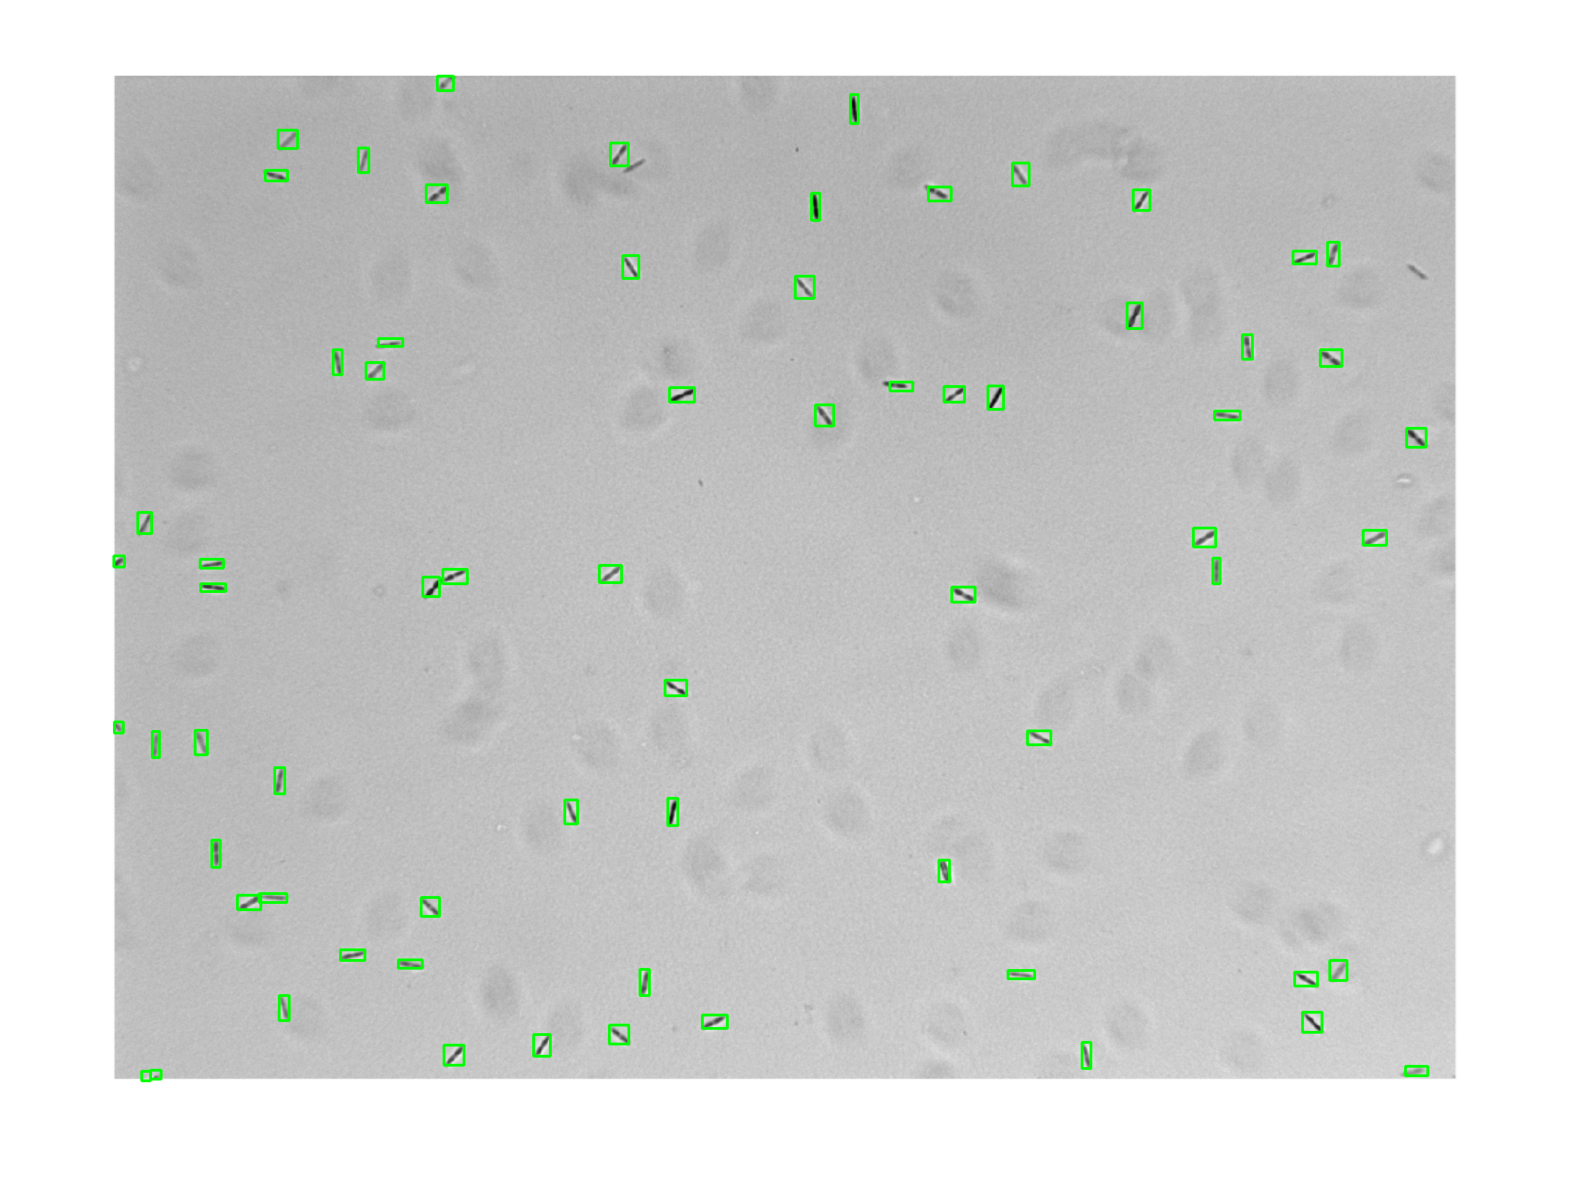

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


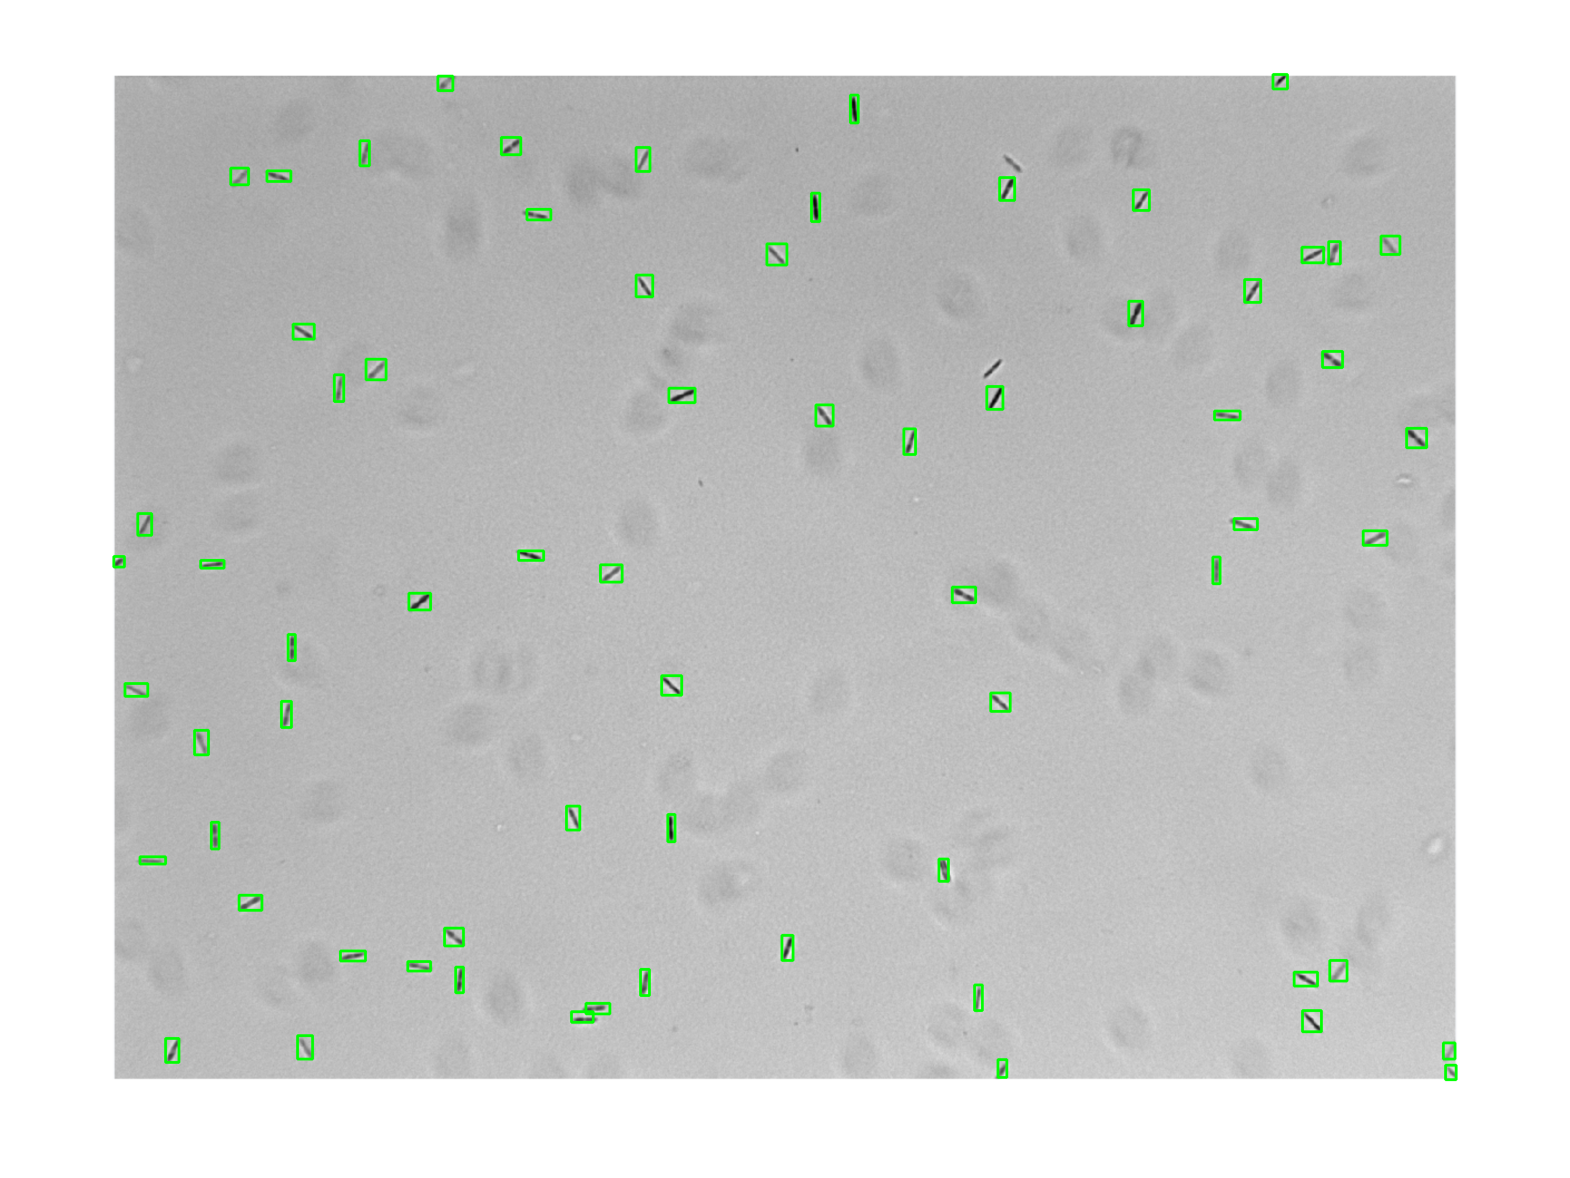

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


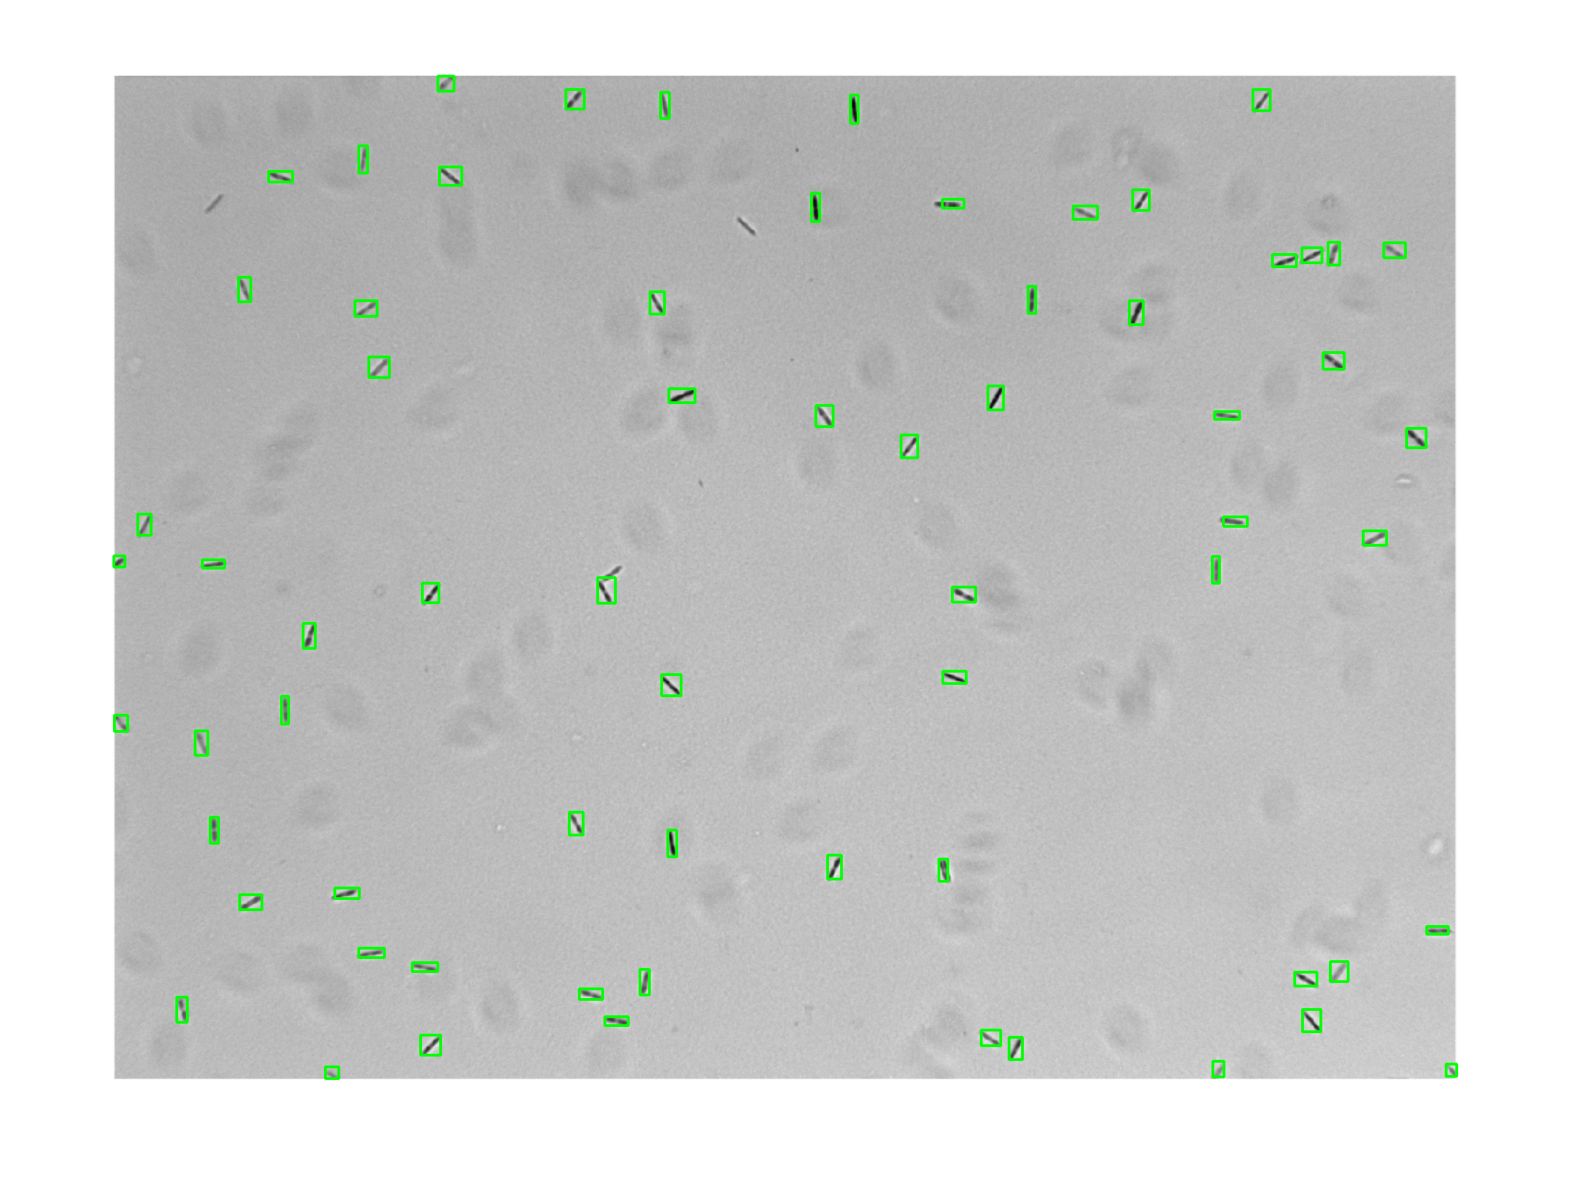

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


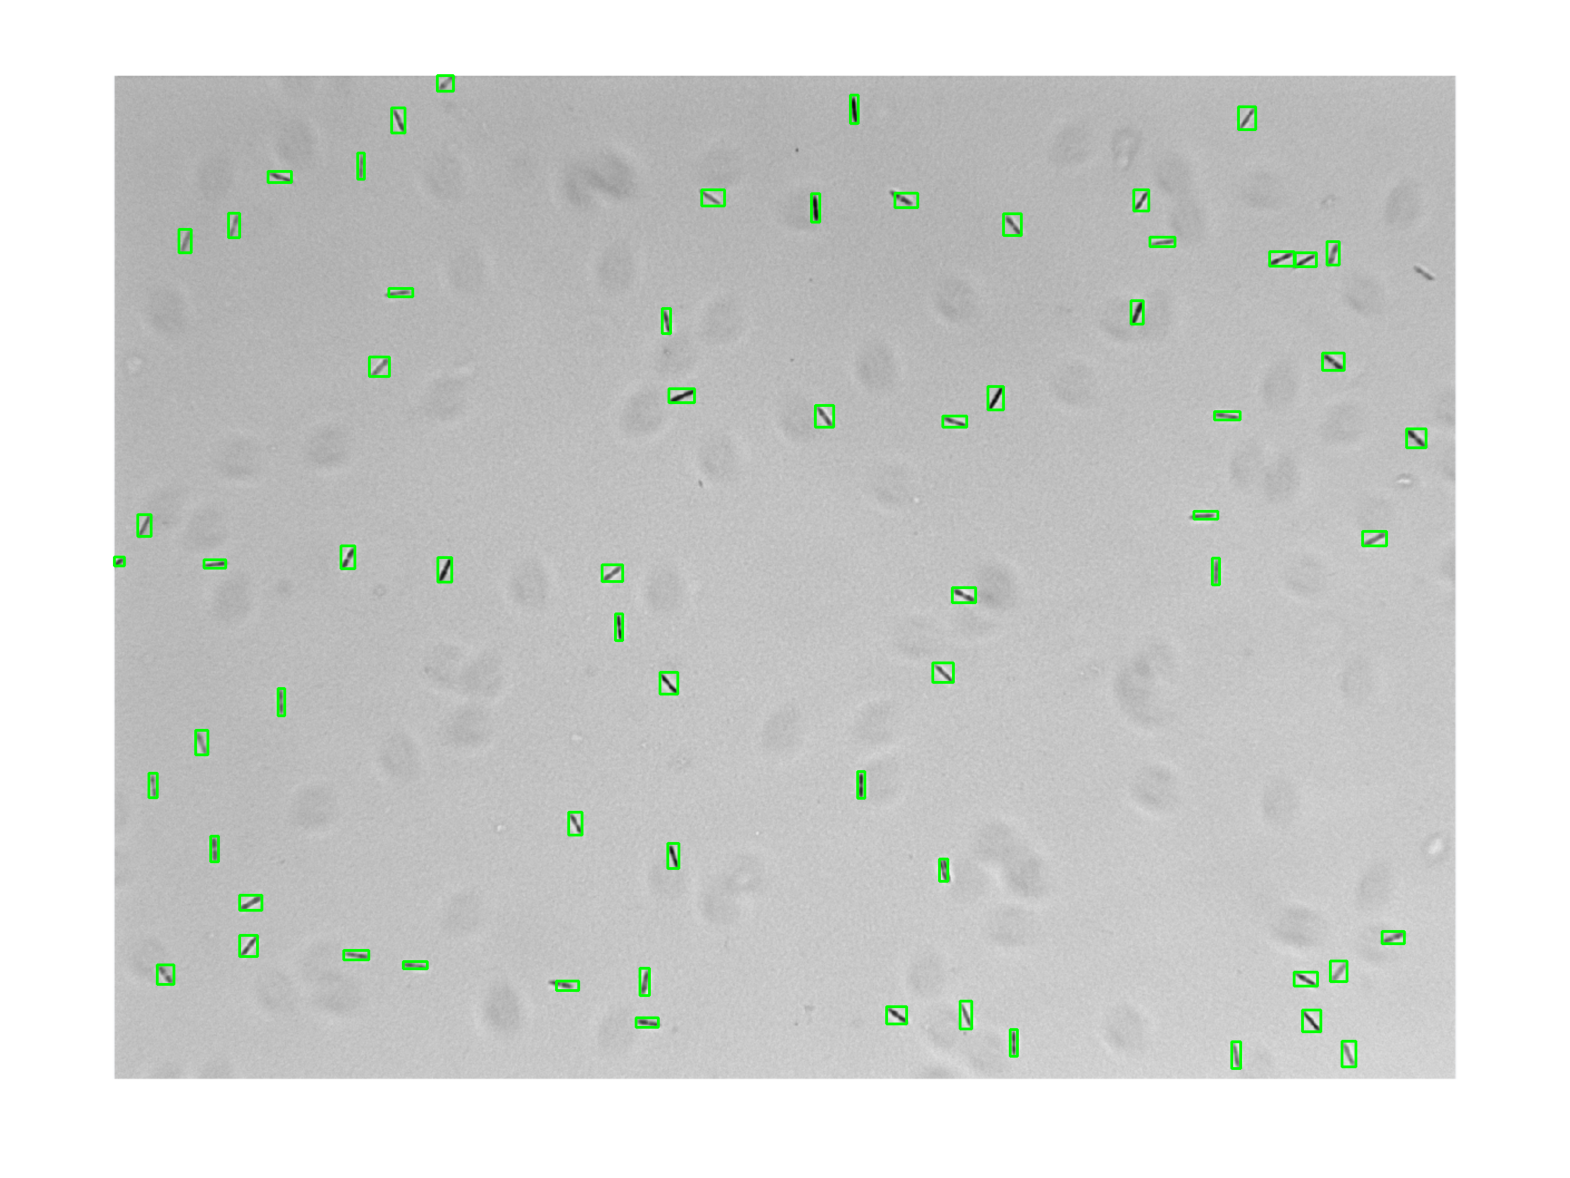

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


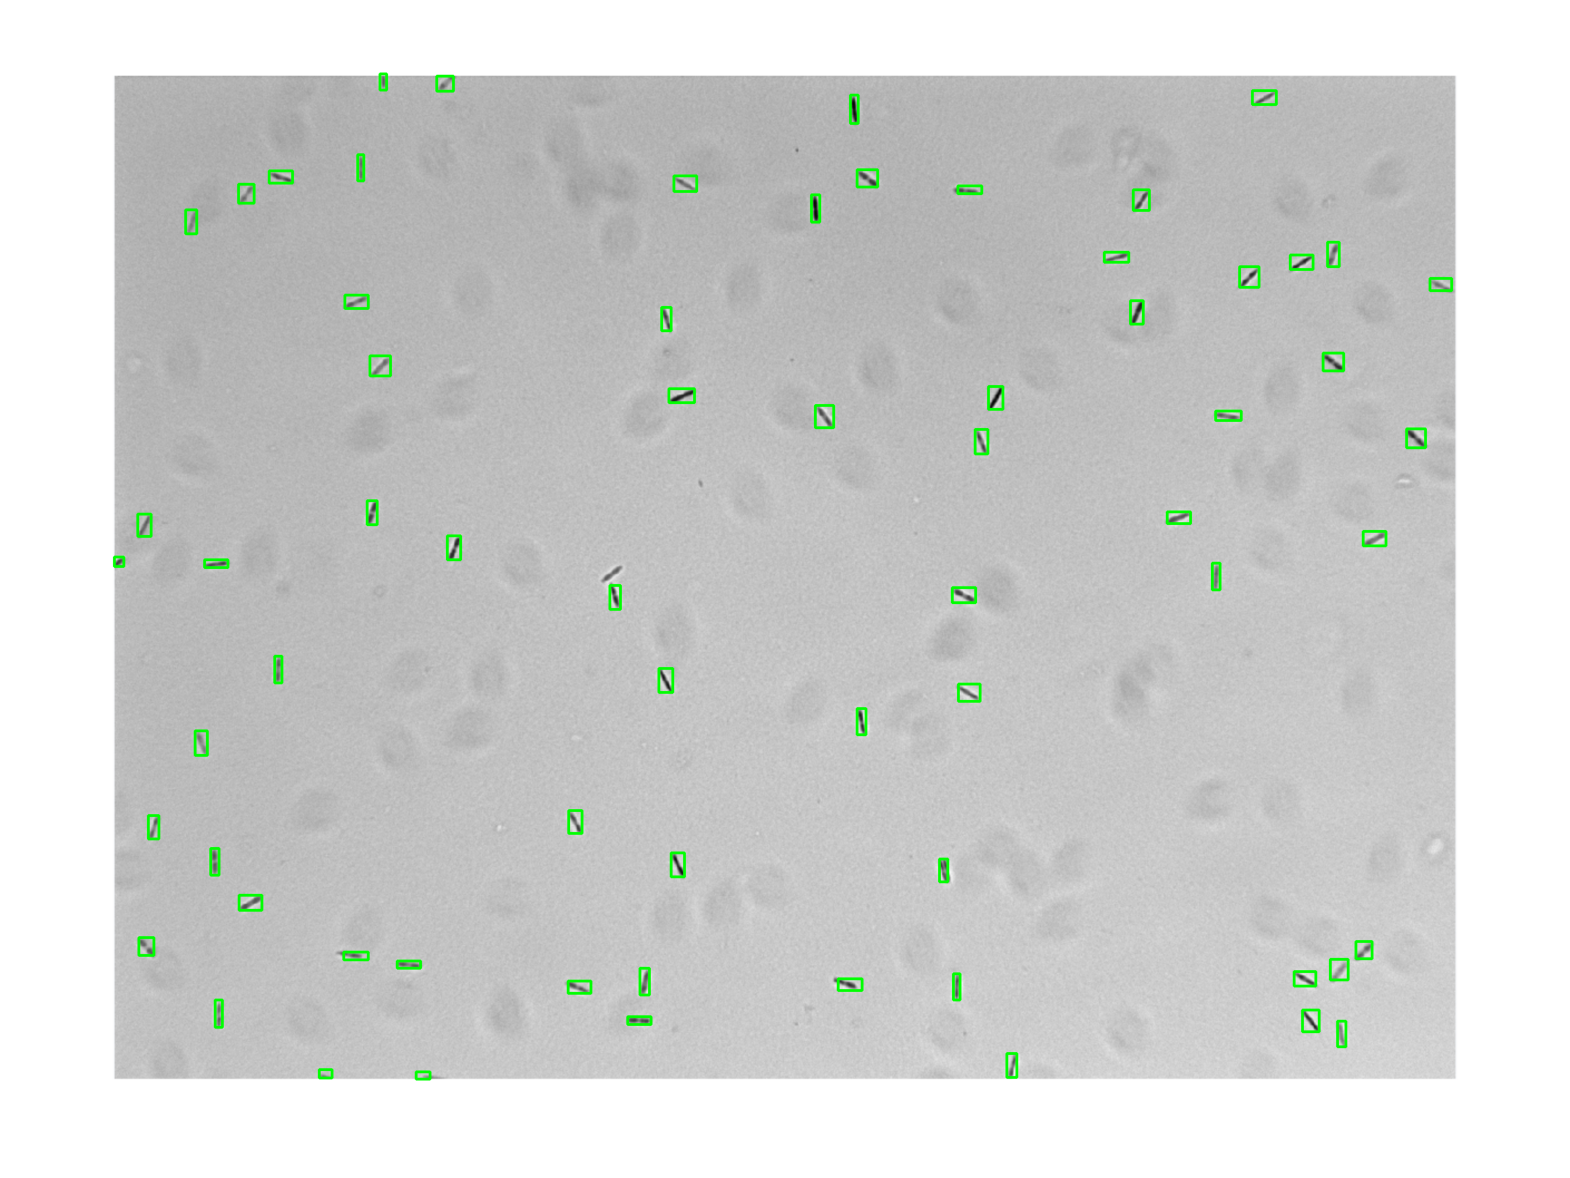

In [24]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    #if ix==10: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs)#, texts=labels, sz=15)

In [18]:
# Save model for use in labeling
# torch.save(model.state_dict(), MODEL_PATH + model_save_name)